# Data preprocessing
---

## imports

In [2]:
import torch
from torch_geometric.datasets import Reddit, Amazon
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader
import random
from torch.functional import F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.loader import NeighborLoader
from models import *
from torch_geometric.data import Data
from umap import UMAP

/home/lucamodica/mambaforge/envs/rigged/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# DATA PREPARATION

In [3]:
# reading the Amazon dataset
amazon_computers_dataset = Amazon(root='data/Amazon', name='Computers')
data = amazon_computers_dataset[0]
data.num_classes = data.y.unique().shape[0]

In [4]:
# print info about the dataset
print("data", data)
print("num nodes", data.num_nodes)
print("Num edges", data.num_edges)
print("num features", data.num_features)
print("is undirected", data.is_undirected())
print("is directed", data.is_directed())

data Data(x=[13752, 767], edge_index=[2, 491722], y=[13752], num_classes=10)
num nodes 13752
Num edges 491722
num features 767
is undirected True
is directed False


In [5]:
def visualize(h, color, additional_text=None):
  z = UMAP(n_components=2).fit_transform(h.detach().cpu().numpy())

  plt.figure(figsize=(8, 8))
  plt.xticks([])
  plt.yticks([])

  plt.title(f'Embedding visualizaation {additional_text}')
  plt.scatter(z[:, 0], z[:, 1], s=50, c=color, cmap="Set2", label=color)
  plt.show()

In [6]:
def create_masks(data, train_ratio, val_ratio):
  num_nodes = data.num_nodes
  indices = list(range(num_nodes))
  np.random.shuffle(indices)
  
  # Create masks
  train_mask = torch.zeros(num_nodes, dtype=torch.bool)
  val_mask = torch.zeros(num_nodes, dtype=torch.bool)
  test_mask = torch.zeros(num_nodes, dtype=torch.bool)
  
  # Set proportions for train, val, and test
  train_end = int(train_ratio * num_nodes)
  val_end = train_end + int(val_ratio * num_nodes)
  train_mask[indices[:train_end]] = True
  val_mask[indices[train_end:val_end]] = True
  test_mask[indices[val_end:]] = True
  
  # Assign the custom masks to the dataset
  data.train_mask = train_mask
  data.val_mask = val_mask
  data.test_mask = test_mask


def train_test_split_graph(data: Data, train_ratio: float, val_ratio: float, batch_size: int):
    """
    Split the graph data into train, validation, and test sets
    :param data: The graph data
    :param train_ratio: The ratio of the training set
    :param val_ratio: The ratio of the validation set
    :param batch_size: The batch size
    
    :return: The train, validation, and test data loaders
    """

    # Call the function to create masks
    create_masks(data, train_ratio, val_ratio)

    # train, validation, and test node indices based on the masks
    train_idx = data.train_mask.nonzero(as_tuple=False).view(-1)
    val_idx = data.val_mask.nonzero(as_tuple=False).view(-1)
    test_idx = data.test_mask.nonzero(as_tuple=False).view(-1)
    
    def create_data_loader(data, indices):
        return DataLoader(data[indices], batch_size=batch_size, shuffle=True)
      
    def create_neighbor_loader(data, indices, batch_size=batch_size):
        return NeighborLoader(data, num_neighbors=[30] * 2, batch_size=batch_size, input_nodes=indices)

    # create the data loaders
    train_loader = create_neighbor_loader(data, train_idx)
    val_loader = create_neighbor_loader(data, val_idx, batch_size=4096*2)
    test_loader = create_neighbor_loader(data, test_idx)

    return train_loader, val_loader, test_loader

# TRAINING

In [7]:
def train_epoch(model, optimizer, data_loader, device, data):
    """Train the model for one epoch using NeighborSampler mini-batches."""
    model.train()
    total_loss = 0

    for batch_size, n_id, adjs in data_loader:
        # `n_id` includes target nodes and all sampled neighbors in this mini-batch
        # `batch_size` is the number of target nodes for which loss should be calculated

        adjs = [adj.to(device) for adj in adjs]  # Move sampled adjacency matrices to GPU

        # Move input features of all nodes in `n_id` to the device
        x_input = data.x[n_id].to(device)
        
        # Compute the model's predictions for the mini-batch
        out = model(x_input, adjs[0].edge_index)
        
        # Calculate loss only for the first `batch_size` target nodes
        loss = F.nll_loss(out[:batch_size], data.y[n_id[:batch_size]].to(device))
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)


@torch.no_grad()
def evaluate(model, data_loader, device, data):
    """Evaluate the model on the validation or test set using NeighborSampler mini-batches."""
    model.eval()
    total_correct = 0

    for batch_size, n_id, adjs in data_loader:
        adjs = [adj.to(device) for adj in adjs]
        
        # Compute predictions for all nodes in the mini-batch
        x_input = data.x[n_id].to(device)
        out = model(x_input, adjs[0].edge_index)

        # Get predictions only for the first `batch_size` target nodes
        pred = out[:batch_size].max(dim=1)[1]
        
        # Compare with the actual labels of the target nodes
        total_correct += (pred == data.y[n_id[:batch_size]].to(device)).sum().item()

    # Calculate accuracy based on the number of target nodes in the entire set
    return total_correct / len(data_loader.dataset)


# METRICS

In [8]:
from sklearn.metrics import f1_score, balanced_accuracy_score


def accuracy(predictions, labels):
    correct = (predictions.argmax(dim=1) == labels).sum().item()
    total = labels.size(0)
    return correct / total


def f1(predictions, labels):
    preds = predictions.argmax(dim=1).cpu().numpy()
    labels = labels.cpu().numpy()
    return f1_score(labels, preds, average='weighted')
  
def balanced_accuracy(predictions, labels):
    preds = predictions.argmax(dim=1).cpu().numpy()
    labels = labels.cpu().numpy()
    return balanced_accuracy_score(labels, preds)

# TRAINING

In [9]:
def train_epoch(model, optimizer, loss_fn, train_loader, device, metrics):
    model.train()
    all_preds = []
    all_labels = []
    losses = []

    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)

        out, h = model(batch.x, batch.edge_index)  # Receive only one output
        loss = loss_fn(out, batch.y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        all_preds.append(out.detach().cpu())
        all_labels.append(batch.y.detach().cpu())
        
    # Concatenate all predictions and labels
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # Compute metrics on the entire dataset
    avg_metrics = {metric_name: metric_fn(all_preds, all_labels) 
                  for metric_name, metric_fn in metrics.items()}
    avg_loss = np.mean(losses)

    return avg_loss, avg_metrics

@torch.no_grad()
def validate(model, loss_fn, val_loader, device, metrics):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    losses = []

    for batch in val_loader:
        batch = batch.to(device)
        out, h = model(batch.x, batch.edge_index)  # Receive only one output
        loss = loss_fn(out, batch.y)

        losses.append(loss.item())
        all_preds.append(out.detach().cpu())
        all_labels.append(batch.y.detach().cpu())
        
    # with torch.no_grad():
    #   _, h = model(val_loader.data.x, val_loader.data.edge_index)
    #   visualize(h, val_loader.data.y)

    # Concatenate all predictions and labels
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # Compute metrics on the entire dataset
    avg_metrics = {metric_name: metric_fn(all_preds, all_labels) 
                  for metric_name, metric_fn in metrics.items()}
    avg_loss = np.mean(losses)

    return avg_loss, avg_metrics

def training_loop(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, device, metrics):
    print("Starting training")
    train_losses, val_losses = [], []
    train_metrics_history = {metric_name: [] for metric_name in metrics}
    val_metrics_history = {metric_name: [] for metric_name in metrics}

    for epoch in range(1, num_epochs + 1):
        # Training
        train_loss, train_metrics = train_epoch(
            model, optimizer, loss_fn, train_loader, device, metrics)
        # Validation
        val_loss, val_metrics = validate(
            model, loss_fn, val_loader, device, metrics)
        
        # Logging results
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        for metric_name in metrics:
            train_metrics_history[metric_name].append(train_metrics[metric_name])
            val_metrics_history[metric_name].append(val_metrics[metric_name])

        # Print metrics
        metrics_str = ', '.join(
            [f'{metric_name}: {train_metrics[metric_name]:.3f} (train), {val_metrics[metric_name]:.3f} (val)'
             for metric_name in metrics])
        print(
            f"Epoch {epoch}/{num_epochs}: "
            f"Loss: {train_loss:.3f} (train), {val_loss:.3f} (val), "
            f"{metrics_str}"
        )

    return model, train_losses, val_losses, train_metrics_history, val_metrics_history

# EXPERIMENT

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
train_ratio = 0.8
val_ratio = 0.1
learning_rate = 0.01  
batch_size = 64
  
train_loader, val_loader, test_loader = train_test_split_graph(
      data, train_ratio, val_ratio, batch_size)

/home/lucamodica/mambaforge/envs/rigged/lib/python3.11/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [11]:
def gnn_experiment(model, train_loader, val_loader):
  print('Training ', model.__class__.__name__)
  
  optimizer = torch.optim.Adam(
      model.parameters(), lr=learning_rate)
  
  loss_fn = torch.nn.CrossEntropyLoss()
  
  metrics = {
    'accuracy': accuracy,
    'f1': f1,
    'balanced_accuracy': balanced_accuracy,
  }
  
  # Train the model
  model, train_losses, val_losses, train_metrics_history, val_metrics_history = training_loop(
    model, optimizer, loss_fn, train_loader, val_loader, num_epochs=10, device=device, metrics=metrics
  )
  
  results = {
    'model': model,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_metrics_history': train_metrics_history,
    'val_metrics_history': val_metrics_history
  }
  torch.save(results, f'output-benchmark/{model.__class__.__name__}_results.pt')
  
  return results

In [26]:
gcn = GCN(in_channels=data.num_node_features, hidden_channels=64, out_channels=data.num_classes).to(device)
gat = GAT(in_channels=data.num_node_features, hidden_channels=64, out_channels=data.num_classes, num_heads=8)
gsage = GraphSAGE(in_channels=data.num_node_features, hidden_channels=64, out_channels=data.num_classes)

In [13]:
# result_dict = {model.__class__.__name__: gnn_experiment(model, train_loader, val_loader) for model in [gsage]}

In [27]:
gcn_results = gnn_experiment(gcn, train_loader, val_loader)
gat_results = gnn_experiment(gat, train_loader, val_loader)
gsage_results = gnn_experiment(gsage, train_loader, val_loader)

Training  GCN
Starting training


/home/lucamodica/mambaforge/envs/rigged/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 1/10: Loss: 0.791 (train), 0.404 (val), accuracy: 0.801 (train), 0.877 (val), f1: 0.798 (train), 0.868 (val), balanced_accuracy: 0.682 (train), 0.816 (val)
Epoch 2/10: Loss: 0.298 (train), 0.347 (val), accuracy: 0.928 (train), 0.894 (val), f1: 0.927 (train), 0.889 (val), balanced_accuracy: 0.905 (train), 0.850 (val)
Epoch 3/10: Loss: 0.224 (train), 0.322 (val), accuracy: 0.952 (train), 0.907 (val), f1: 0.952 (train), 0.906 (val), balanced_accuracy: 0.939 (train), 0.882 (val)
Epoch 4/10: Loss: 0.186 (train), 0.304 (val), accuracy: 0.965 (train), 0.911 (val), f1: 0.965 (train), 0.911 (val), balanced_accuracy: 0.954 (train), 0.891 (val)
Epoch 5/10: Loss: 0.160 (train), 0.289 (val), accuracy: 0.973 (train), 0.917 (val), f1: 0.973 (train), 0.918 (val), balanced_accuracy: 0.965 (train), 0.913 (val)
Epoch 6/10: Loss: 0.150 (train), 0.277 (val), accuracy: 0.974 (train), 0.922 (val), f1: 0.974 (train), 0.921 (val), balanced_accuracy: 0.966 (train), 0.906 (val)
Epoch 7/10: Loss: 0.130 (tra

/home/lucamodica/mambaforge/envs/rigged/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 1/10: Loss: 0.569 (train), 0.212 (val), accuracy: 0.833 (train), 0.935 (val), f1: 0.832 (train), 0.935 (val), balanced_accuracy: 0.729 (train), 0.932 (val)
Epoch 2/10: Loss: 0.128 (train), 0.151 (val), accuracy: 0.963 (train), 0.952 (val), f1: 0.963 (train), 0.951 (val), balanced_accuracy: 0.956 (train), 0.942 (val)
Epoch 3/10: Loss: 0.078 (train), 0.107 (val), accuracy: 0.978 (train), 0.969 (val), f1: 0.978 (train), 0.969 (val), balanced_accuracy: 0.975 (train), 0.976 (val)


/home/lucamodica/mambaforge/envs/rigged/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 4/10: Loss: 0.079 (train), 0.100 (val), accuracy: 0.978 (train), 0.971 (val), f1: 0.978 (train), 0.971 (val), balanced_accuracy: 0.968 (train), 0.976 (val)
Epoch 5/10: Loss: 0.043 (train), 0.101 (val), accuracy: 0.988 (train), 0.969 (val), f1: 0.988 (train), 0.969 (val), balanced_accuracy: 0.986 (train), 0.976 (val)
Epoch 6/10: Loss: 0.021 (train), 0.069 (val), accuracy: 0.995 (train), 0.981 (val), f1: 0.995 (train), 0.981 (val), balanced_accuracy: 0.994 (train), 0.986 (val)


/home/lucamodica/mambaforge/envs/rigged/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 7/10: Loss: 0.042 (train), 0.070 (val), accuracy: 0.987 (train), 0.979 (val), f1: 0.987 (train), 0.979 (val), balanced_accuracy: 0.987 (train), 0.985 (val)
Epoch 8/10: Loss: 0.017 (train), 0.085 (val), accuracy: 0.995 (train), 0.974 (val), f1: 0.995 (train), 0.974 (val), balanced_accuracy: 0.994 (train), 0.979 (val)


/home/lucamodica/mambaforge/envs/rigged/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 9/10: Loss: 0.050 (train), 0.080 (val), accuracy: 0.986 (train), 0.977 (val), f1: 0.986 (train), 0.977 (val), balanced_accuracy: 0.982 (train), 0.981 (val)
Epoch 10/10: Loss: 0.019 (train), 0.056 (val), accuracy: 0.995 (train), 0.986 (val), f1: 0.995 (train), 0.986 (val), balanced_accuracy: 0.994 (train), 0.990 (val)


## EVALUATION

In [28]:
root_output = 'output-benchmark'

results_dict = {
    gcn.__class__.__name__: torch.load(f'{root_output}/{gcn.__class__.__name__}_results.pt'),
    gat.__class__.__name__: torch.load(f'{root_output}/{gat.__class__.__name__}_results.pt'),
    gsage.__class__.__name__: torch.load(f'{root_output}/{gsage.__class__.__name__}_results.pt'),
    'mlp': torch.load(f'{root_output}/mlp_results.pt'),
}

/tmp/ipykernel_323636/2854468222.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gcn.__class__.__name__: torch.load(f'{root_output}/{gcn.__class__.__name__}_results.pt')

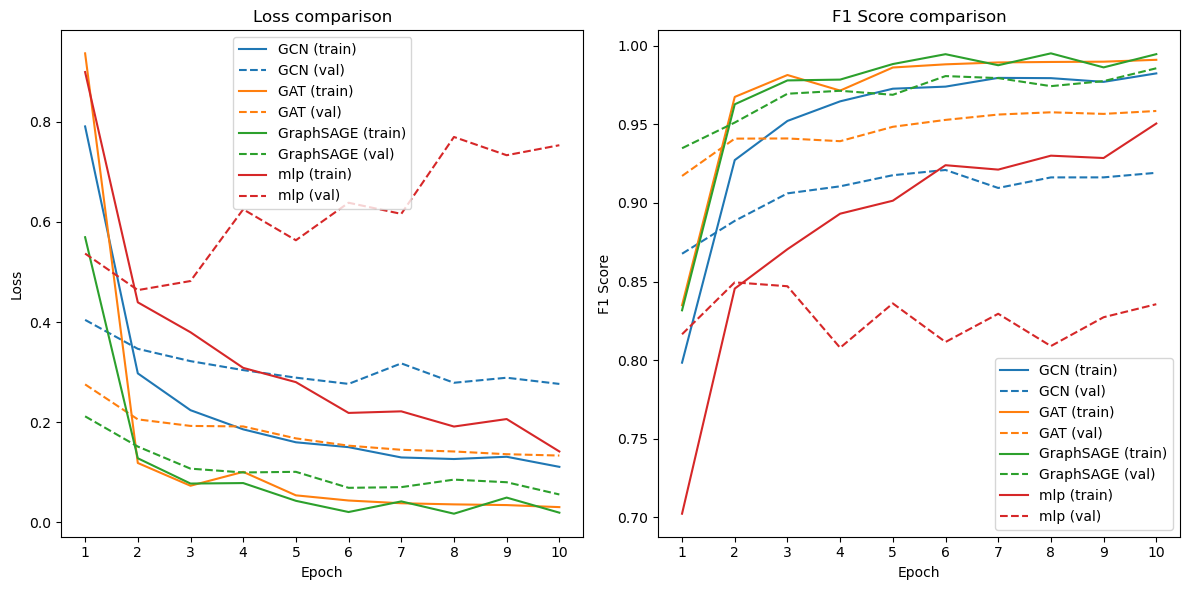

In [29]:
import itertools


def plot_losses_and_f1(results_dict, num_epochs=10):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    epochs = range(num_epochs)

    # Define a color cycle to assign consistent colors per model
    color_cycle = itertools.cycle(
        plt.rcParams['axes.prop_cycle'].by_key()['color'])

    # Dictionary to store the color for each model
    model_colors = {}

    # Plot training and validation losses in the first subplot
    axs[0].set_title('Loss comparison')
    for model_name, result in results_dict.items():
        # Assign a color to the model if it hasn't been assigned yet
        if model_name not in model_colors:
            model_colors[model_name] = next(color_cycle)

        color = model_colors[model_name]
        axs[0].plot(epochs, result['train_losses'],
                    label=f'{model_name} (train)', color=color)
        axs[0].plot(epochs, result['val_losses'],
                    label=f'{model_name} (val)', color=color, linestyle='dashed')

    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_xticks(ticks=epochs, labels=[str(i+1) for i in epochs])
    axs[0].legend()

    # Plot F1 scores in the second subplot
    axs[1].set_title('F1 Score comparison')
    for model_name, result in results_dict.items():
        # Use the same color as for the loss plot
        color = model_colors[model_name]
        axs[1].plot(epochs, result['train_metrics_history']['f1'],
                    label=f'{model_name} (train)', color=color)
        axs[1].plot(epochs, result['val_metrics_history']['f1'],
                    label=f'{model_name} (val)', color=color, linestyle='dashed')

    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('F1 Score')
    axs[1].set_xticks(ticks=epochs, labels=[str(i+1) for i in epochs])
    axs[1].legend()

    plt.tight_layout()
    plt.show()


def plot_f1(results_dict):
    fig, axs = plt.subplots(1, 1, figsize=(7, 7))
    epochs = range(10)

    # Define a color cycle to assign consistent colors per model
    color_cycle = itertools.cycle(
        plt.rcParams['axes.prop_cycle'].by_key()['color'])

    # Dictionary to store the color for each model
    model_colors = {}

    # Plot F1 scores in the second subplot
    axs.set_title('F1 Score')
    for model_name, result in results_dict.items():
        # make model name capitalized
        model_name = model_name.upper()
        # Assign a color to the model if it hasn't been assigned yet
        if model_name not in model_colors:
            model_colors[model_name] = next(color_cycle)

        color = model_colors[model_name]
        axs.plot(epochs, result['val_metrics_history']['f1'],
                 label=f'{model_name} (val)', color=color, linestyle='dashed')
        axs.plot(epochs, result['train_metrics_history']['f1'],
                 label=f'{model_name} (val)', color=color)

    axs.set_xlabel('Epoch')
    axs.set_ylabel('F1 Score')
    axs.set_xticks(ticks=epochs, labels=[str(i+1) for i in epochs])
    axs.legend()

    plt.tight_layout()
    plt.show()

plot_losses_and_f1(results_dict)

In [30]:
# for each model in the results_dict, compute and put in a table the test accuracy, balanced accouracy and f1 score.
# afterwards, show the results in a table where the rows are the models and the columns are the metrics
@torch.no_grad()
def compute_test_metrics(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    for batch in test_loader:
        batch = batch.to(device)
        out, h = model(batch.x, batch.edge_index)
        all_preds.append(out.detach().cpu())
        all_labels.append(batch.y.detach().cpu())

    # Concatenate all predictions and labels
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    metrics = {
        'accuracy': accuracy,
        'f1': f1,
        'balanced_accuracy': balanced_accuracy,
    }

    test_metrics = {metric_name: metric_fn(all_preds, all_labels)
                    for metric_name, metric_fn in metrics.items()}

    return test_metrics
  
@torch.no_grad()
def compute_mlp_test_metrics(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch.x)
        all_preds.append(out.detach().cpu())
        all_labels.append(batch.y.detach().cpu())

    # Concatenate all predictions and labels
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    metrics = {
        'accuracy': accuracy,
        'f1': f1,
        'balanced_accuracy': balanced_accuracy,
    }

    test_metrics = {metric_name: metric_fn(all_preds, all_labels)
                    for metric_name, metric_fn in metrics.items()}

    return test_metrics 

for model_name, result in results_dict.items():
    if model_name == 'mlp':
      test_metrics = compute_mlp_test_metrics(result['model'], test_loader, device)
    else:
      test_metrics = compute_test_metrics(result['model'], test_loader, device)
    
    results_dict[model_name]['test_metrics'] = test_metrics

In [31]:
results_df = pd.DataFrame(
    {model_name: result['test_metrics']
        for model_name, result in results_dict.items()}
).T

print(results_df)

           accuracy        f1  balanced_accuracy
GCN        0.983357  0.983321           0.979827
GAT        0.991416  0.991422           0.991381
GraphSAGE  0.997307  0.997307           0.997655
mlp        0.931561  0.931509           0.912893
